In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%load_ext autoreload
%autoreload 2
import collections
import datetime
import pandas as pd
from itertools import count
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from tensorflow import set_random_seed
pd.options.display.max_rows = 12


Using TensorFlow backend.


## Description
The task consists in eliminate outliers of a time series data, for this purpose we are working with a dataset of humidity. The data can be found here: https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv/download

### Load and Explore Data

In [2]:
# Import data and focus in the humidity
data = pd.read_csv('weather_madrid_lemd_1997_2015.csv.zip', usecols=['CET',' Mean Humidity'])
data.rename(columns={" Mean Humidity": "Humidity"}, inplace=True)
data.head()


,CET,Humidity
0,1997-1-1,95.0
1,1997-1-2,92.0
2,1997-1-3,85.0
3,1997-1-4,63.0
4,1997-1-5,95.0


In [3]:
data.dtypes


CET          object
Humidity    float64
dtype: object

In [4]:
data.describe()


,Humidity
count,6810.000000
mean,57.971366
std,19.675744
min,15.000000
25%,41.000000
50%,59.000000
75%,74.000000
max,100.000000


In [5]:
data.isnull().sum()


CET         0
Humidity    2
dtype: int64

In [6]:
data.dropna(inplace=True)
data.isnull().sum()


CET         0
Humidity    0
dtype: int64

Text(0.5, 1.0, 'Humidity Time Series')

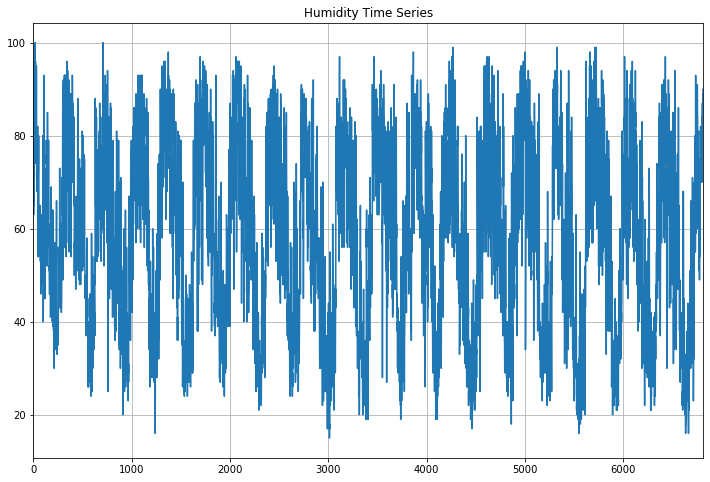

In [7]:
data['Humidity'].plot(figsize=(12,8), grid=True)
plt.title("Humidity Time Series")


Text(0.5, 1.0, 'Humidity Histogram')

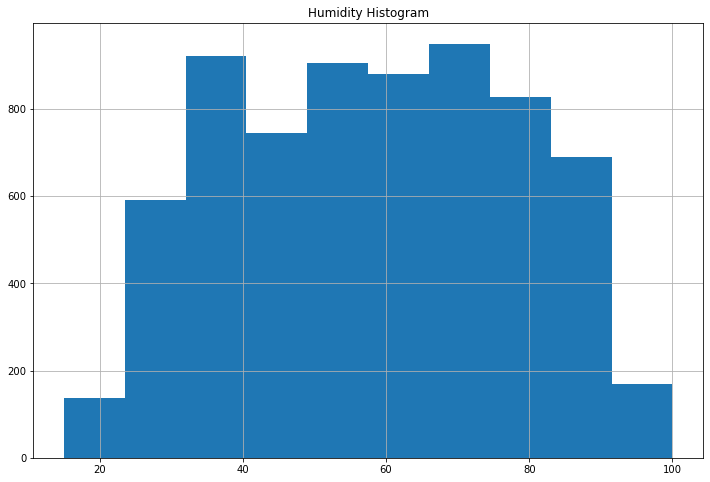

In [8]:
data['Humidity'].hist(figsize=(12,8), grid=True)
plt.title("Humidity Histogram")


# Aproach 1: Use Moving Average method to find outliers or anomalies in time series data

In [9]:
def mov_average(data, window_size):
    """Funcion to calculate the moving average
    Args: data=>(pandas.dataframe): Data to apply moving_average
          window_size=> (int) : Size of the window to use 
          
    Returns:=> (numpy.array): Moving average using convolution
    """

    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def find_outliers(y, window_size, sigma=2.0):
    """Funcion find outliers based on moving_average
    Args: y=>(numpy.array): Data fo find outliers
          window_size=> (int) : Size of the window to use 
          sigma => (float): constant to use in the funcion
          
    Returns:=> (dictionary): Dictionary with the std and the outliers
    values 
    """
        
    avg = mov_average(y, window_size).tolist()
    residual = y - avg
    std = np.std(residual)
    return {'std': round(std, 3),
            'out_lier_dic': collections.OrderedDict([(index, y_i) for index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}



In [10]:
"""Calculate the different windows to find the best one 
   depending on the len of outliers and loss(mse) """

windows = range(2,11)
losses = list()
X = data['Humidity'].values
len_outliers = []
for window in windows:
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    history = [X[i] for i in range(window)]
    outliers = find_outliers(X,window)
    len_outliers.append(len(outliers['out_lier_dic']))
    for t in range(len(test)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window,length)])
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    losses.append(mean_squared_error(test, predictions))


In [11]:
"""Print len of the outliers for each window """
len_outliers


[389, 386, 362, 374, 341, 346, 335, 328, 345]

In [12]:
"""Print the losses(mse) of the outliers for each window """
losses


[98.27445652173913,
 107.03695542170641,
 113.87229099324126,
 119.17396620132257,
 123.34895731269188,
 126.6515702856183,
 129.37797706556896,
 131.53778039177243,
 133.4415338235294]

##### By analazying the mean and the len_outliers and the losses, we can see that the minimum is the postion 2, meaning the value of window is 4 with that value we can plot the outliers 

In [13]:
window = 4
test = [X[i] for i in range(window, len(X))]
predictions = list()
history = [X[i] for i in range(window)]
outliers = find_outliers(X,window)
len_outliers.append(len(outliers['out_lier_dic']))
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    

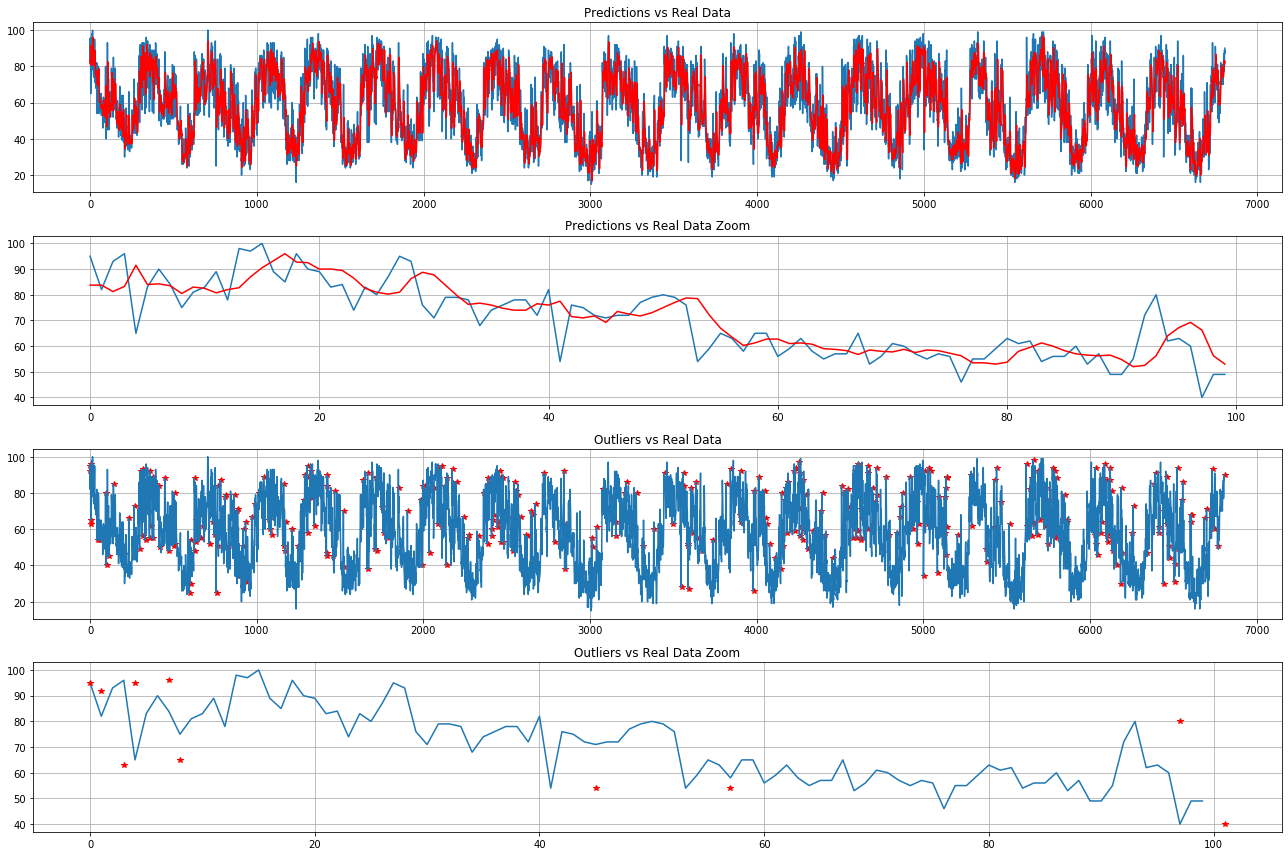

In [14]:
"""Plot the different figures to compare and find outliers """

#Define Figure format
plt.figure(1, figsize=(18,12))
#Figure 1 Prediction vs Real Data
plt.tight_layout()
plt.subplot(411)
plt.title("Predictions vs Real Data")
plt.plot(test)
plt.plot(predictions, color='red')
plt.grid(True)

#Figure 2 Prediction vs Real Data Zoom
plt.subplot(412)
plt.title("Predictions vs Real Data Zoom")
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.grid(True)
plt.tight_layout()


# Save the outliers in a list so that we can visualize them
x_outliers = np.fromiter(outliers['out_lier_dic'].keys(), dtype=int, count=len(outliers['out_lier_dic']))
y_outliers = np.fromiter(outliers['out_lier_dic'].values(), dtype=float,count=len(outliers['out_lier_dic']))

#Figure 3 Outliers vs Real Data
plt.subplot(413)
plt.title("Outliers vs Real Data")
plt.plot(x_outliers, y_outliers, "r*")
plt.plot(test)
plt.grid(True)
plt.tight_layout()


#Figure 4 Outliers vs Real Data Zoom
plt.subplot(414)
plt.title("Outliers vs Real Data Zoom")
plt.plot(test[0:100])
plt.plot(x_outliers[0:10], y_outliers[0:10], "r*")
plt.grid(True)
plt.tight_layout()


# Aproach 2: Use Autoencoders with LSTM to find outliers or anomalies in the time series data

In [15]:
"""Divide data in test and train set """
train = data['Humidity'][:int(len(data['Humidity'])*0.8)]
test = data['Humidity'][int(len(data['Humidity'])*0.8):]
train_idx = train.index
test_idx = test.index


In [16]:
train = np.expand_dims(train,axis=1)
train.shape


(5448, 1)

In [17]:
test = np.expand_dims(test,axis=1)
test.shape


(1362, 1)

In [18]:
"""Standarize the data to train the algorithm """
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)


In [19]:
"""Reshape data according to LSTM tensor model """
x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1])
x_test.shape


(1362, 1, 1)

In [20]:
# Set random seed
np.random.seed(10)
set_random_seed(10)


In [21]:
def autoencoder_model(x):
    """Function to define autoencoder
    Args: x=>(tensor): Data to train in the LSTM AE
    First creates the compress representation of input data (Encoder)
    Then repeat data to distribute info to the decoder
    Then reconstruc the data (Decoder)
    
    Returns:=> (keras.model): Keras model of LSTM AE
    """
    inputs = Input(shape=(x.shape[1], x.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(x.shape[1])(L2)
    L4 = LSTM(4,activation='relu', return_sequences=True)(L3) 
    L5 = LSTM(16,activation='relu', return_sequences=True)(L4) 
    output = TimeDistributed(Dense(x.shape[2]))(L5)
    model = Model(inputs=inputs, outputs = output)
    return model


In [22]:
# Call of the model and define optimizer and loss
model = autoencoder_model(x_train)
model.compile(optimizer='adam', loss= 'mean_absolute_error')
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              17        
Total 

In [23]:
#Define parameters of the training
nb_epochs = 10
batch_size = 10
history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.10).history


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4903 samples, validate on 545 samples
Epoch 1/10
4903/4903 [==============================] - 9s 2ms/step - loss: 0.2183 - val_loss: 0.0626
Epoch 2/10
4903/4903 [==============================] - 4s 742us/step - loss: 0.0527 - val_loss: 0.0318
Epoch 3/10
4903/4903 [==============================] - 4s 917us/step - loss: 0.0185 - val_loss: 0.0110
Epoch 4/10
4903/4903 [==============================] - 4s 778us/step - loss: 0.0104 - val_loss: 0.0116
Epoch 5/10
4903/4903 [==============================] - 4s 813us/step - loss: 0.0083 - val_loss: 0.0064
Epoch 6/10
4903/4903 [==============================] - 3s 679us/step - loss: 0.0067 - val_loss: 0.0059
Epoch 7/10
4903/4903 [==============================] - 4s 731us/step - loss: 0.0049 - val_loss: 0.0037
Epoch 8/10
4903/4903 [==============================] - 4s 716us/step - loss: 0.0050 - val_loss: 0.0036
Epoch 9/10
4903/4903 [=====

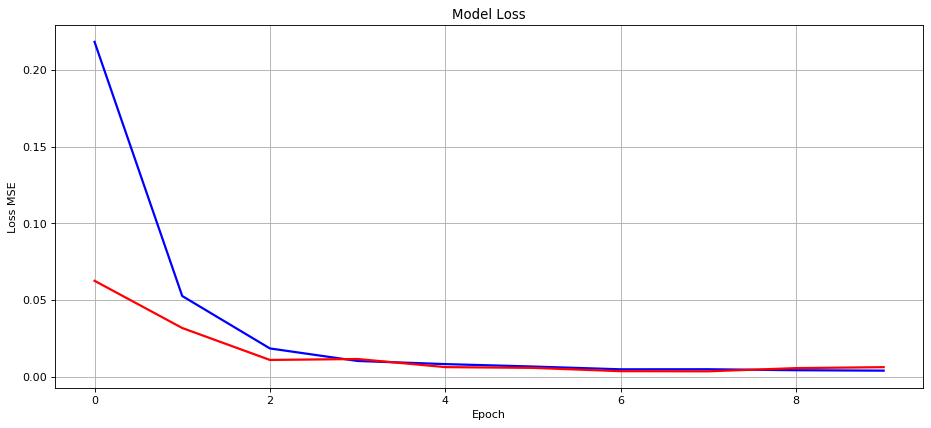

In [24]:
"""Visualization of the training and validtion loss  """
fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label = 'Train', linewidth=2)
ax.plot(history['val_loss'],'r', label = 'Validation', linewidth=2)
ax.set_title("Model Loss")
ax.set_ylabel("Loss MSE")
ax.set_xlabel("Epoch")
plt.grid(True)
plt.show()


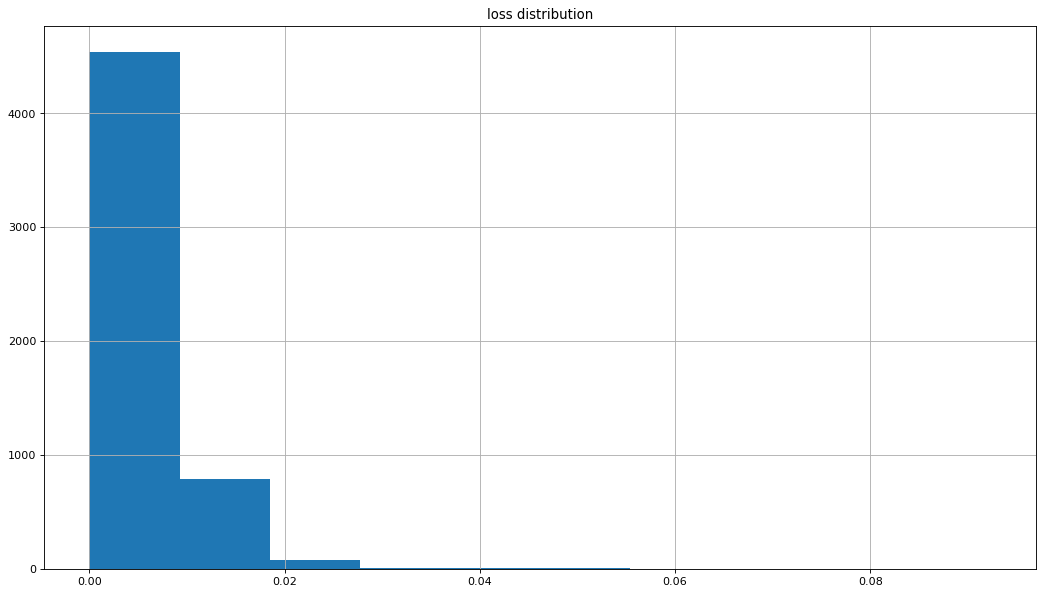

In [25]:
"""Visualization loss distribution to define a threshold based on training data 
to detect outliers  """

x_pred = model.predict(x_train)
x_pred = x_pred.reshape(x_pred.shape[0],x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=['Humidity'])
x_pred.index = train_idx

scored = pd.DataFrame(index=train_idx)
xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['loss_mse'] = np.mean(np.abs(x_pred-xtrain), axis=1)
plt.figure(figsize=(16,9),dpi=80)
plt.title("loss distribution")
scored['loss_mse'].hist()

#Define treshhold
threshold = 0.02


In [26]:
"""Obtain values of the prediction and classify as outlier (True) or 
not outlier(False) based on the threshold found previously"""

x_pred = model.predict(x_test)
x_pred = x_pred.reshape(x_pred.shape[0],x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=['Humidity'])
x_pred.index = test_idx

scored = pd.DataFrame(index=test_idx)
xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
scored['loss_mse'] = np.mean(np.abs(x_pred-xtest), axis=1)
scored['Threshold'] = threshold
scored['Outlier'] = scored['loss_mse'] > scored['Threshold']
scored.head()


,loss_mse,Threshold,Outlier
5450,0.004965,0.02,False
5451,0.004308,0.02,False
5452,0.004336,0.02,False
5453,0.006755,0.02,False
5454,0.004624,0.02,False


In [27]:
# Count number of outliers in test 
scored['Outlier'].value_counts()


False    1284
True       78
Name: Outlier, dtype: int64

In [28]:
"""Obtain values of the prediction for all the dataset
and then compare with threshold to find outliers"""
x_pred_train = model.predict(x_train)
x_pred_train = x_pred_train.reshape(x_pred_train.shape[0],x_pred_train.shape[2])
x_pred_train = pd.DataFrame(x_pred_train, columns=['Humidity'])
x_pred_train.index = train_idx

scored_train = pd.DataFrame(index=train_idx)
scored_train['loss_mse'] = np.mean(np.abs(x_pred_train-xtrain), axis=1)
scored_train['Threshold'] = threshold
scored_train['Outlier'] = scored_train['loss_mse'] > scored_train['Threshold']
scored = pd.concat([ scored_train,scored])
scored.head()


,loss_mse,Threshold,Outlier
0,0.025932,0.02,True
1,0.009972,0.02,False
2,0.014445,0.02,False
3,0.006007,0.02,False
4,0.025932,0.02,True


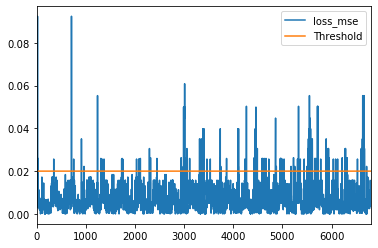

In [29]:
# "Visualization of the Threshold and outliers with respect to the loss MSE"
scored.plot()


In [30]:
# Count number of outliers in entire dataset
scored['Outlier'].value_counts()


False    6618
True      192
Name: Outlier, dtype: int64

In [31]:
# Obtain the index of the outliers and the values to plot and visualize them
out_liers_idx = scored.loc[scored['Outlier'] == True]
data['Humidity'][test].index


Float64Index([55.0, 56.0, 50.0, 65.0, 51.0, 67.0, 57.0, 43.0, 41.0, 54.0,
              ...
              78.0, 78.0, 84.0, 83.0, 87.0, 77.0, 78.0, 89.0, 87.0, 90.0],
             dtype='float64', length=1362)

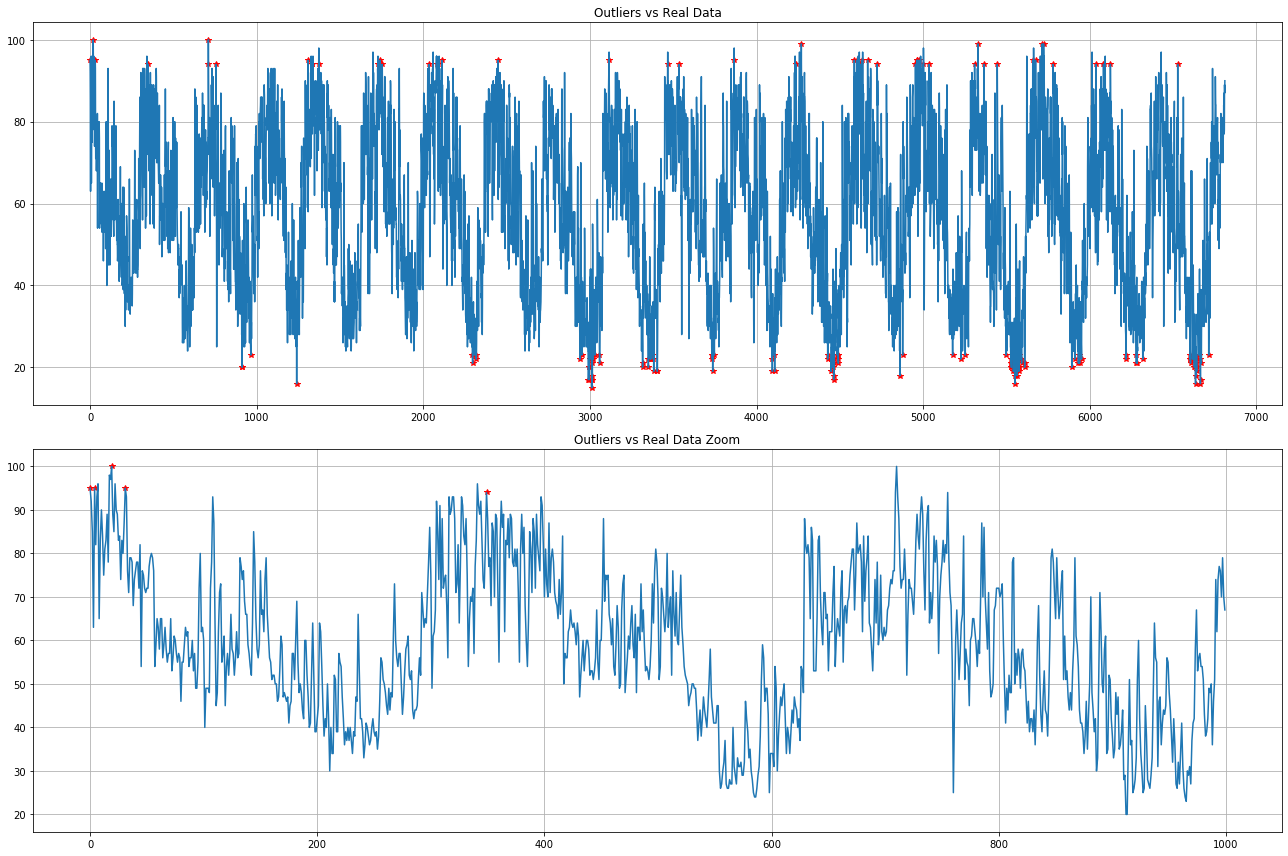

In [32]:
"""Visualization of the outliers in the entire data and in the 
zoom where we find outliers """
x_outliers = data['Humidity'][out_liers_idx.index].index
y_outliers = data['Humidity'][out_liers_idx.index].values
plt.figure(1, figsize=(18,12))
plt.subplot(211)
plt.title("Outliers vs Real Data")
plt.plot(x_outliers, y_outliers, "r*")
plt.plot(data['Humidity'])
plt.grid(True)
plt.tight_layout()

plt.subplot(212)
plt.title("Outliers vs Real Data Zoom")
plt.plot(x_outliers[0:5], y_outliers[0:5], "r*")
plt.plot(data['Humidity'][:1000])
plt.grid(True)
plt.tight_layout()
